# Predicting Spotify Song Popularity

Taylor Willingham<br>
June 2019
<img src="Images/Color-Spotify-Logo.jpg" alt="spotify logo" width="200"/>

### Introduction

This project predicts popular songs through supervised machine learning. Initially, I approached the problem through linear regression, attempting to predict the popularity values between 0 and 100. After this proved ineffective, I adapted the problem to use classification. In order to train and test such a model, this particular project utilizes data originating from the Spotify API, which can be found <a href='https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/'>here</a>. Although this capstone specifically uses custom metrics as determined by Spotify, the hope is that the concepts explored here could be generalized for broader use. This notebook and, more broadly, its corresponding github repository cover the steps followed, as well as the project findings. 

<div id="toc"></div>

## Overview

<b>The Problem:</b> The music marketplace is a fickle place. Artists that once topped the charts fall out of favor, while new artists may unexpectedly take the spotlight. There never seems to be a definite pattern and, regardless of what any one person may know, it’s practically impossible to predict which songs will make the cut.<br>
<br>
With that in mind, if we take the task of prediction out of the hands of the decision makers and turn it over instead to a predictive model, perhaps the model can find a pattern that humans might overlook. By knowing which songs are popular on Spotify and the characteristics of those songs, perhaps we can find correlations algorithmically that will provide a little more certainty when guessing the next ‘hit’.<br>

<b>Client:</b> It’s important to clarify that the goal of this capstone project is not to make personal recommendations. This is not guided by the tastes of a specific user in order to make suggestions for that user. Rather, this project looks at popular songs in a collective sense, as determined by the general population. As such, the intended target is more along the lines of a music programmer or an A&R executive: someone who would benefit from knowing which songs will have the most impact. These decision makers choose which songs to promote based on what they think will most likely hold a listener’s attention, and any tool that can help them improve their accuracy will help them to be more effective in that role.<br>

<b>Data:</b> The data for this project originates from a Kaggle dataset that can be found <a href='https://www.kaggle.com/tomigelo/spotify-audio-features'>here.</a> Each observation represents an individual song. In the original dataset, there are approximately 130,000 rows and 17 columns, though there were some modifications that are discussed in the next section, Exploring the Data. The majority of the features consist of numerical values providing a score on various musical qualities including: loudness, instrumentalness, danceability, liveness and other similar descriptors. Other columns consist of simple string objects, some of which were dropped, and a few others were converted from numeric to categorical to better represent the information. Finally, the last column, the target column, lists a popularity score between 0 and 100 for each song. Here's a sample of how the data is structured.<br>

<img src="Images/first_row.png" alt="first observation" width="930"/>

<b>Approach:</b> Based on the data, the natural way to approach this problem is through linear regression. Though the range is limited, the target variable is numeric and scalar, and predicting the popularity values through linear regression makes sense. Unfortunately, as the models section below will reveal, the regression results were very poor, even after regularization. The visualizations confirm that the data points are not concentrated in any obvious way meaning the variability of the residuals is very high.<br>
<br>
Because of this, I made the decision to tackle the problem using a classification approach. I added a column to the dataset to give each observation one of three labels depending on its popularity score. This simplifies the prediction objective, but still serves the client's purpose. Someone reviewing a song doesn't need to know necessarily if a song would score a popularity of 60 or 70, he or she would simply need to quickly know if a song has potential and is worth further investment, or if it doesn't deserve further attention.<br>
<br>
The decision to use a classification approach opened the door to several different algorithm options. Starting simple with something like a single decision tree and gradually testing more complex models like Random Forest and AdaBoost, the results tend to improve with increased complexity. The conclusion section lays out these results, and helps understand the tradeoffs. It is up to the stakeholders to determine what best suits their need.

## Exploring the Data

<b>Section Overview</b><br>
This section discusses shaping and visualizing the data. It comes from a relatively clean Kaggle dataset, so there weren't really any missing values to deal with. However, I did make a few changes involving dropping columns, sorting the data for easier analysis and changing some of the datatypes. After a brief inspection of the dataset as a whole, this section then takes a closer look at the target variable itself, before further examining correlations and relationships between the various features and the dependent variable. Finally, there are a number of visualizations, primarily different scatterplots, to get a better understanding of the trends. 

<img src="Images/pairgrid.png" alt="feature pairgrid" width="350"/>

<b>Load in the data and packages</b><br>
The first step is to import the needed packages.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

### Shaping the data
With the workstation set up, the next obvious step is to load and shape the data. To get the dataset into a format better suited for analysis, I chose to sort the observations  by their popularity scores and start the index from 1. This helps assess where songs rank compared to other songs. This is just for exploratory purposes, and the data will be re-shuffled later to try to avoid any unintented bias with the machine learning models.

In [2]:
spotify = pd.read_csv('Data/SpotifyFeatures0419.csv')

# Create the sorted dataframe, drop zeros, convert any categoricals
sort_data = spotify.sort_values('popularity', ascending=False).reset_index()
spotify_ordered = sort_data.drop(['index', 'track_id'], axis=1)
spotify_ordered.index = spotify_ordered.index + 1

spotify_ordered = spotify_ordered[spotify_ordered.popularity > 0]

spotify_ordered[['mode', 'key', 'time_signature']] = \
    spotify_ordered[['mode', 'key', 'time_signature']].astype('category')

A significant adjustment above is that all songs with a populartiy of zero were dropped, a reduction of 18,889 rows. This decision was made because of the low barrier of entry for songs to be hosted on Spotify, and the hope is that by removing these observations we can cut down on the noise in the dataset. Another change is the three columns that were changed to the type of category.<br>
<br>
For more insight into these and other decisions regarding data restructuring, refer to the data wrangling notebook in the Reports sub-folder of this repository, which can be found <a href='https://github.com/twillstw/Spotify-Popularity-Prediction/blob/master/Reports/1.%20Data%20Wrangling.ipynb'>here.</a>

In [3]:
spotify_ordered.shape

(111774, 16)

After dropping all of the observations with a popularity of zero, roughly 111,800 rows remain. Furthermore, there are 15 features and one target variable. Looking at the first few rows shows the types of features and gives a sense of how the data is sorted.

In [4]:
spotify_ordered.head()

,artist_name,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,popularity
1,Daddy Yankee,Con Calma,0.1100,0.737,193227,0.860,0.000002,8,0.0574,-2.652,0,0.0593,93.989,4,0.656,100
2,Post Malone,Wow.,0.1630,0.833,149520,0.539,0.000002,11,0.1010,-7.399,0,0.1780,99.947,4,0.385,98
3,Billie Eilish,bad guy,0.3080,0.708,194088,0.418,0.093000,0,0.1000,-10.998,1,0.3680,131.926,4,0.578,98
4,Post Malone,Sunflower - Spider-Man: Into the Spider-Verse,0.5200,0.744,158040,0.494,0.000000,2,0.0716,-5.563,1,0.0699,89.972,4,0.927,98
5,Jonas Brothers,Sucker,0.0427,0.842,181040,0.734,0.000000,1,0.1060,-5.065,0,0.0588,137.958,4,0.952,98


<b>Adding a new column</b><br>
The linear regression models were ineffective, so I eventually decided to tackle this problem using a classification approach. To do so, I split the observations into three classes based on the popularity scores: `unpopular` for scores up to 50, `medium` for 51 to 74, and `popular` for 75 and above. I chose these labels based partially on concentrations found in the data, but mostly the choices were made based on intuition. Below is the code to set up and inspect the new column specifying the labels. 

In [5]:
classified = spotify_ordered.copy()
classified['pop_rating'] = ''

for i, row in classified.iterrows():
    score = 'unpopular'
    if (row.popularity > 50) & (row.popularity < 75):
        score = 'medium'
    elif row.popularity >= 75:
        score = 'popular'
    classified.at[i, 'pop_rating'] = score

In [6]:
# Inspect the new column
classified[['track_name', 'popularity', 'pop_rating']].head(3)

,track_name,popularity,pop_rating
1,Con Calma,100,popular
2,Wow.,98,popular
3,bad guy,98,popular


### Visual EDA

Now that the data is loaded and shaped, it's important to get an understanding of the different variables, in particular the target variable. First, here's a plot to visualize the distribution of the target variable values.

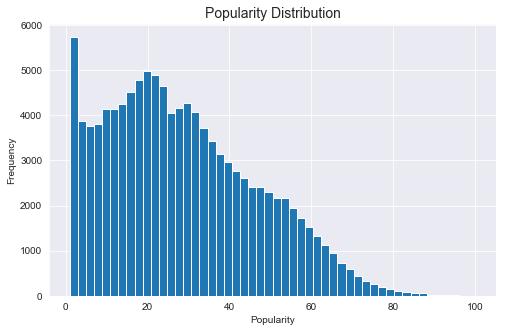

In [7]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = spotify_ordered['popularity'].plot(kind='hist', bins=50)
_ = plt.xlabel('Popularity')
_ = plt.title('Popularity Distribution', fontsize=14)

Even with the zero values dropped, the popularity scores are heavily weighted towards the bottom of the scale, and the distribution tapers off severely as it moves towards the higher popularity values. To study this dynamic further, we can look at the statistical moments for the popularity column.

In [8]:
spotify_ordered[['popularity']].describe()

,popularity
count,111774.000000
mean,28.300132
std,18.398418
min,1.000000
25%,14.000000
50%,26.000000
75%,41.000000
max,100.000000


From the above we can see the low measures of centrality. The mean and median are both in the 20s and the IQR only extends to 41. Even songs of a medium popularity as defined in the classified dataset would be fairly rare. This makes sense given that popular radio is often branded as "Top 40" and there are thousands of songs in  the data, but the large imbalance will need to be accounted for later on.

<b>Correlations</b><br>
Having  examined the target variable, we can now examine the rest of the features and see how they correlate with each other, in particular how they correlate with the popularity column.

In [9]:
spotify_ordered.corr()

,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity
acousticness,1.000000,-0.359877,0.049087,-0.737737,0.320986,-0.113883,-0.631248,-0.125848,-0.218866,-0.182997,-0.152114
danceability,-0.359877,1.000000,-0.147489,0.294570,-0.341741,-0.119567,0.443299,0.251208,0.063790,0.457178,0.194267
duration_ms,0.049087,-0.147489,1.000000,-0.041508,0.073682,-0.006783,-0.049664,-0.115628,-0.017789,-0.157237,-0.038537
energy,-0.737737,0.294570,-0.041508,1.000000,-0.336212,0.205073,0.782896,0.111446,0.235635,0.323009,0.151448
instrumentalness,0.320986,-0.341741,0.073682,-0.336212,1.000000,-0.070851,-0.527086,-0.213433,-0.099311,-0.282644,-0.201522
liveness,-0.113883,-0.119567,-0.006783,0.205073,-0.070851,1.000000,0.072658,0.114989,0.001880,0.011129,-0.039396
loudness,-0.631248,0.443299,-0.049664,0.782896,-0.527086,0.072658,1.000000,0.072990,0.227240,0.329304,0.272248
speechiness,-0.125848,0.251208,-0.115628,0.111446,-0.213433,0.114989,0.072990,1.000000,0.050433,0.129835,0.009084
tempo,-0.218866,0.063790,-0.017789,0.235635,-0.099311,0.001880,0.227240,0.050433,1.000000,0.096504,0.046398
valence,-0.182997,0.457178,-0.157237,0.323009,-0.282644,0.011129,0.329304,0.129835,0.096504,1.000000,0.045007


To also visualize these correlations, a heatmap is useful.

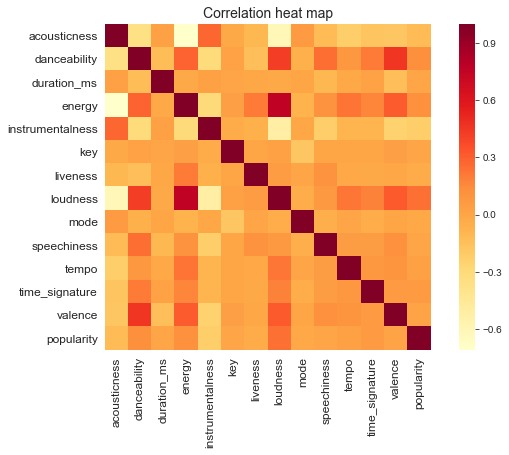

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
_ = sns.heatmap(spotify.corr(), square=True, cmap='YlOrRd')
_ = plt.title('Correlation heat map', fontsize=14)
_ = plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

From the above chart and heatmap, the correlations are mostly pretty weak. Energy, loudness and danceability have fairly strong relationships, which makes sense, and acousticness is naturally opposed to loudness and energy, but there's not much to go on outside of those. Unfortunately, this trend appears to hold true for the popularity variable. The correlation between loudness and popularity looks positive, but it would be nice to have a dependent variable that strongly relates to the target variable.

<b>Further examining specific variables</b><br>
Having established a general overview of the dependent and independent variables, the next step is to dive deeper into these relationships. The next several plots explore the relationship between certain features and the target variable. First, two functions are defined in order to create multiple plots.

In [10]:
def scat_plot(x, y, hue=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.scatterplot(x, y, hue=hue, s=12)
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.legend(fontsize=12)
    plt.show()
    
    
def regress_plot(x='', y='', data=None, xlab='', ylab='', titl=''):
    '''Plots a scatterplot with a regression line
    using given inputs'''
    fig, ax = plt.subplots(figsize=(10,6))
    _ = sns.regplot(x, y, data=data, scatter_kws={"s": 10}, line_kws={'color':'r'})
    _ = plt.xlabel(xlab, fontsize=12)
    _ = plt.ylabel(ylab, fontsize=12)
    _ = plt.title(titl, fontsize=14)
    _ = plt.ylim(-3, 103)
    plt.show()

From the correlation heatmap, the best predictor seemed to be loudness. The newly defined `scat_plot` function can be used to examine it further.

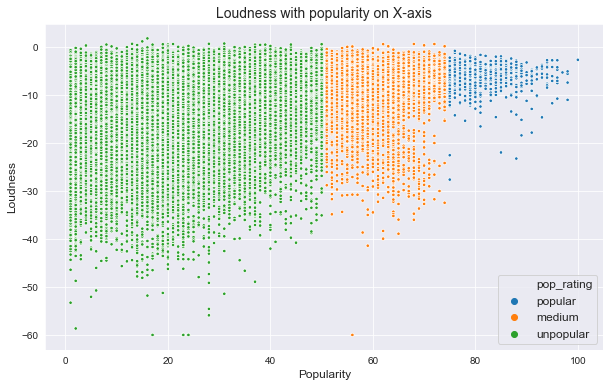

In [11]:
s = spotify_ordered

scat_plot(s.popularity, s.loudness, hue=classified.pop_rating, xlab='Popularity',\
         ylab='Loudness', titl='Loudness with popularity on X-axis')

The plot above shows the distribution of loudness with popularity on the X-axis. It shows that the highest values of loudness can be found acoss the popularity spectrum, but as the X-axis increases the groupings become more and more concentrated toward the top. In other words, loudness doesn't guarantee popularity, but low levels of loudness seem to preclude popularity.<br>
<br>
Now with the `regress_plot` function:

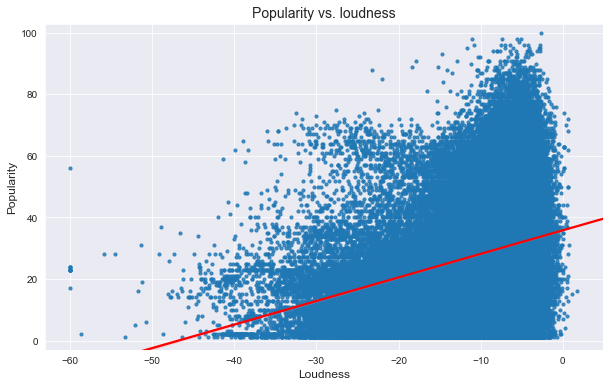

In [16]:
regress_plot('loudness', 'popularity', data=s, xlab='Loudness',\
         ylab='Popularity', titl='Popularity vs. loudness')

The regressor clearly shows there is a positive correlation, and the data tends to narrow towards the top, but overall the observations are quite scattered. It's not a very strong fit.<br>
<br>
While loudness has the strongest correlation, for comparison sake, let's look at the other end of the spectrum with instrumentalness. Again, we can do so with both the `scat_plot` and `regress_plot`.

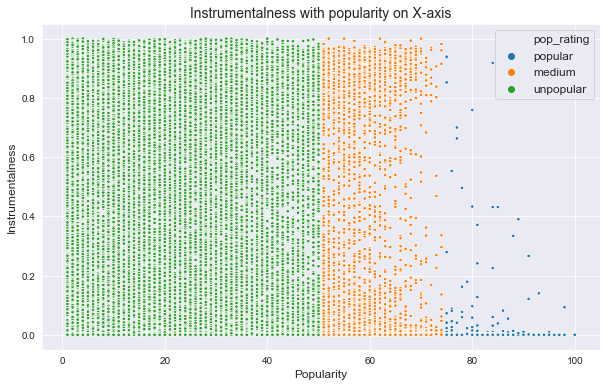

In [12]:
scat_plot(s.popularity, s.instrumentalness, hue=classified.pop_rating, xlab='Popularity',\
         ylab='Instrumentalness', titl='Instrumentalness with popularity on X-axis')

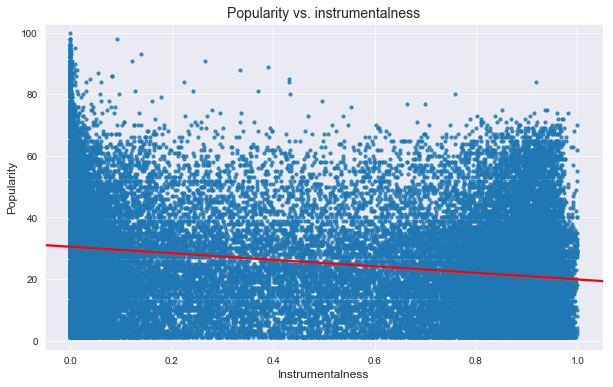

In [14]:
regress_plot('instrumentalness', 'popularity', data=s, xlab='Instrumentalness',\
         ylab='Popularity', titl='Popularity vs. instrumentalness')

Again, there isn't a strong fit for the data as a whole, but the most popular songs do tend to concentrate in one spot at the bottom of the instrumentalness range. That is encouraging as it might give the later models something to grab when predicting popular songs.

Continuing to look at a couple other variables, we can quickly examine energy and danceability using subplots.

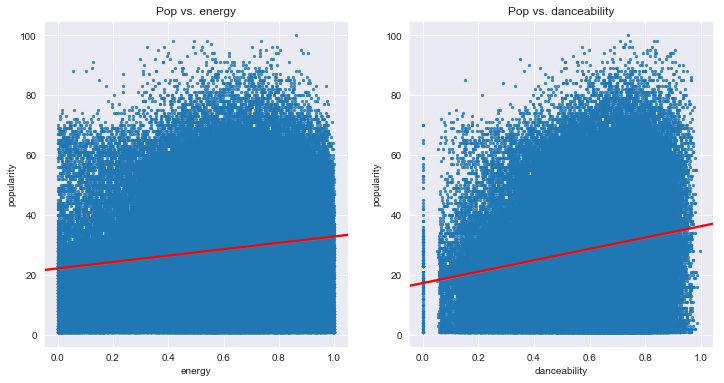

In [17]:
fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot(1,2,1)
_ = sns.regplot(s.energy, s.popularity, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Pop vs. energy')

ax2 = plt.subplot(1,2,2)
_ = sns.regplot(s.danceability, s.popularity, scatter_kws={"s": 5}, line_kws={'color':'r'})
_ = plt.title('Pop vs. danceability')

The story for these variables is similar to the previous ones. 

In general, the EDA shows that the data is heavily weighted towards unpopular songs and that there is a lot of noise and variability amongst the observations. But honestly, thinking intuitively about song popularity, this shouldn't be too surprising. Unpopular songs and popular songs can have many similarities, and all popular songs can have many differences. The purpose of this project is to see if an algorithm can sort out these differences and similarities better than a human could. That is what the next section looks into.<br>
<br>
For further exploratory analysis, refer to the Data Story and EDA reports found <a href="https://github.com/twillstw/Spotify-Popularity-Prediction/tree/master/Reports">here</a>.

## Modeling

<b>Section overview</b><br>
This sections outlines the steps used to find the best algorithm for predicting popularity. First, I wanted to set aside a few observations from a few popular artists to use as example cases to demonstrate the final model. With those removed from the full dataset, the next step was to run a <b>linear regression</b> model. As mentioned previously, even with regularization using <b>ridge regression</b>, the results were still very poor. This is supported by the many visualizations above. To combat this problem, I decided to transition to a classification approach. After splitting the training and final test sets, done manually to ensure the imbalanced class ratios are preserved, I started simple by applying a <b>decision tree</b> model. From there, I worked my way up to ensemble methods using <b>bagging</b>, <b>Random Forest</b> and <b>boosting</b>, which improved the accuracy. 

<b>Example cases</b><br>
Here I set aside a few use case examples by removing the songs for the following artists: Shakira, Jonas Brothers, Tame Impala, and The Weeknd. This isn't a test set to verify the model performance after training -- that is done later -- but just a small set to help demonstrate the ability of the final model. These four artists, each with at least one popular song, represent a few different musical genres. 

In [7]:
artists = ['Shakira', 'Jonas Brothers', 'Tame Impala', 'The Weeknd']

# Create a list of indices corresponding to the artists above
# The first comprehension creates a list of lists, the second flattens it into one
to_drop = [classified[classified.artist_name == name].index.tolist() for name in artists]
to_drop = [ind for sub in to_drop for ind in sub]

# Gather the test cases
df_x = classified.copy()
cases = df_x[df_x.index.isin(to_drop)]

# Remove the test cases from data
classified.drop(to_drop, inplace=True)
spotify_ordered.drop(to_drop, inplace=True)

The original row count was 111,774. Here we can verify the new shape.

In [8]:
print(classified.shape)
print(spotify_ordered.shape)

(111762, 17)
(111762, 16)


### Linear Regression
With the example cases removed, the rest of the data is used here for training and testing a linear regression model using Scikit Learn. One important step is that the `spotify_ordered` dataset is shuffled to ensure that the song order does not introduce any bias, and the new shuffled data is stored as `reg_data`. For this initial test, to keep it as simple as possible, the categorical variables are omitted. 

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Set random state
state=25

# Shuffle the data
reg_data = spotify_ordered.sample(frac=1, random_state=state).reset_index(drop=True)

# First, try without categoricals
X = reg_data.select_dtypes(include='number').drop('popularity', axis=1)
y = reg_data.popularity

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=state)

Now that the data has been split with `train_test_split`, we can fit the training data and calculate the R<sup>2</sup> score. This process, and all the similar ones to follow, is timed to get an understanding of the computational requirements for each model.<br>
<br>
In addition to the standard R<sup>2</sup> score, I also created a custom loss function to give a more concrete perspective on the model performance. This function, `custom_loss`, calculates counts for different levels of error between the predicted values and the actual test values, and also gives an overall average of the differences between predicted and actual.

In [10]:
def custom_loss(prediction, actual):
    paired = zip(prediction, actual)
    listed = list(paired)
    diffs = {'Under five': 0, 'Five to ten': 0, 'Over ten': 0, 'Average error': 0}
    sum = 0

    for pair in listed:
        sum += abs(pair[0] - pair[1])
        if abs(pair[0] - pair[1]) < 5:
            diffs['Under five'] += 1
        elif 5 <= abs(pair[0] - pair[1]) < 10:
            diffs['Five to ten'] += 1
        else:
            diffs['Over ten'] += 1
            
    diffs['Average error'] = sum / len(listed)
     
    return diffs

With the custom loss function set and the data split, we can begin running the models.

In [11]:
%%time

linreg = LinearRegression()
linreg.fit(X_train, y_train)

lin_pred = linreg.predict(X_test)

print(linreg.score(X_test, y_test))

0.09785133473998608
Wall time: 78.1 ms


In [12]:
custom_loss(lin_pred, y_test)

{'Under five': 5842,
 'Five to ten': 5453,
 'Over ten': 16646,
 'Average error': 14.23847872585166}

The score for the model above is not very good. On the other hand, the custom metric isn't as bad as the score would lead one to believe. There may be over 16,000 predictions well off the mark, but a good many were reasonably accurate, and the average difference isn't terrible.<br>
<br>
To take it a step further, let's see what happens when using the categoricals by using one hot encoding with `.get_dummies()`. For this step, I decided to drop the `artist_name` column. While song popularity is often correlated with artist popularity, the hope is for this model to work just as well on an artist it hasn't seen before. Part of the goal is to be able to discover new talent, and that becomes more difficult if the algorithm is inclined to discredit a song just because it doesn't recognize the artist. Therefore, the column is dropped for training purposes. This new dataset is stored as `df_encoded`.

In [13]:
no_artist = reg_data.drop(['artist_name', 'track_name'], axis=1)
df_encoded = pd.get_dummies(no_artist)
df_encoded.columns

Index(['acousticness', 'danceability', 'duration_ms', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo',
       'valence', 'popularity', 'key_0', 'key_1', 'key_2', 'key_3', 'key_4',
       'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'mode_0', 'mode_1', 'time_signature_0', 'time_signature_1',
       'time_signature_3', 'time_signature_4', 'time_signature_5'],
      dtype='object')

We can see above that the category variables have been separated into unique columns for each respective value. With the new data, new train and test splits need to be created, and the model re-run.

In [14]:
XX = df_encoded.drop('popularity', axis=1)
yy = df_encoded.popularity

X_train, X_test, y_train, y_test = train_test_split(XX, yy, test_size=0.25, random_state=state)

Now fit and check the score:

In [15]:
%%time
lr = LinearRegression()
lr.fit(X_train, y_train)

lr_pred = lr.predict(X_test)

print(lr.score(X_test, y_test))

0.0993840543915483
Wall time: 93.4 ms


And now the custom score:

In [16]:
custom_loss(lr_pred, y_test)

{'Under five': 5824,
 'Five to ten': 5497,
 'Over ten': 16620,
 'Average error': 14.224251302517295}

The result is better, but only marginally. To help ensure this result is accurate, cross-validation can be used.

In [17]:
from sklearn.model_selection import cross_val_score

# Use the regressor from above to set up the cross_val
cvals = cross_val_score(lr, XX, yy, cv=6)

# check the results
print(cvals)
print('The mean cross-validatoin score is: {num:.{dig}f}'.format\
      (num=np.mean(cvals), dig=4))

[0.097934   0.10668441 0.09505961 0.095926   0.10660753 0.09992833]
The mean cross-validatoin score is: 0.1004


The results are fairly similar across all of the folds, and the mean score is about the same as all of the previous results.

This seems to indicate that plain linear regression isn't well suited for this problem, which isn't surprising. To improve on it, I tried using ridge regression next.

#### Ridge regression
In an attempt to improve the results from the basic linear regression model, we can use ridge regression. 

In [18]:
%%time
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=0.5, normalize=True)
ridge.fit(X_train, y_train)

print(ridge.score(X_test, y_test))

0.08705278469931688
Wall time: 67.6 ms


In [19]:
custom_loss(ridge.predict(X_test), y_test)

{'Under five': 5743,
 'Five to ten': 5334,
 'Over ten': 16864,
 'Average error': 14.341524602463956}

This first attempt is worse than basic linear regression, but we can try to improve the result with grid-search cross validation.

In [20]:
from sklearn.model_selection import GridSearchCV

alphas = {'alpha': [0.0005, 0.0006, 0.00075, 0.0009, 0.001]}

rg = Ridge(normalize=True)

rg_cv = GridSearchCV(rg, alphas, cv=6)

rg_cv.fit(XX, yy)

print(rg_cv.best_params_)
print(rg_cv.best_score_)

{'alpha': 0.00075}
0.10035685624500996


The ridge model improved, but it's still more or less the same os basic regression.

<b>Plotting actual versus predicted values</b><br>
The plot below might give a clue as to why the linear models are performing so poorly. The range of predicted values is much narrower than the actual popularity values. This makes sense when thinking about linear regressions and recalling the plots from the data story report: The prediction is a single line through a cloud of observations. This is similar to what is seen in the plot below.

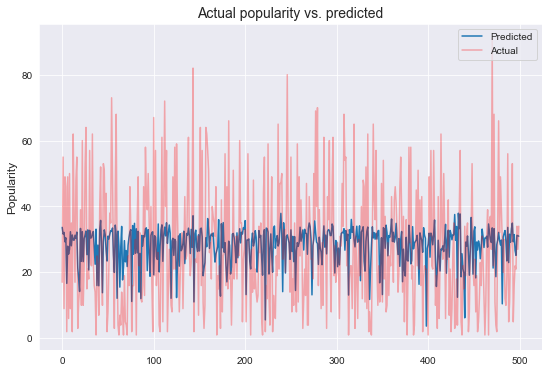

In [33]:
fig = plt.subplots(figsize=(9,6))
_ = plt.plot(list(rg_cv.predict(X_test))[:500], label='Predicted')
_ = plt.plot(list(y_test)[:500], c='r', alpha=0.3, label='Actual')
_ = plt.legend(loc='upper right')
_ = plt.ylabel('Popularity', fontsize=12)
_ = plt.title('Actual popularity vs. predicted', fontsize=14)

### Classification
Because the regression models are not getting the job done, the next step is to use the `classified` dataset and try a classification approach.

<b>Class counts</b><br>
The different classes in the classified dataset exhibit a high level of imbalance. This needs to be accounted for in order to ensure the models perform as well as possible. Here's a visualization of the disparity.

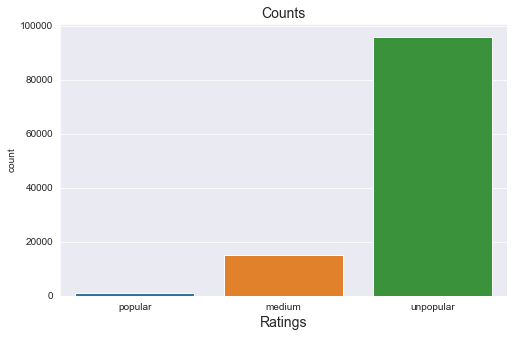

In [34]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
_ = sns.countplot(x='pop_rating', data=classified)
_ = plt.xlabel('Ratings', fontsize=14)
_ = plt.title('Counts', fontsize=14)

##### Creating a balanced sample for the final test set
Instead of using a random sample for the final test set, here I manually create the test set in order to preserve the ratios of the labels.<br>
<br>
First, as before with the encoded dataframe from the regression model, I drop the `artist_name` column, along with `track_name`, and encode the categorical variables.

In [22]:
df = classified.drop(['artist_name', 'track_name'], axis=1)
df = pd.get_dummies(df, columns=['key', 'mode', 'time_signature'])
df.shape

(111762, 31)

Next, I create a separate dataframe with all the observations for each label, and then split each of those into train and test splits. All of the training splits and then all of the test splits are then stitched together so that all labels are represented in the data. Importantly, the popularity column is dropped completely to ensure that it is not included as a training feature.

In [23]:
from sklearn.model_selection import train_test_split

df_pop = df[df.pop_rating == 'popular']

df_med = df[df.pop_rating == 'medium']

df_unpop = df[df.pop_rating == 'unpopular']

# Set random seed
state=25

X_tr_p, X_ts_p, y_tr_p, y_ts_p = train_test_split(df_pop.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_pop.pop_rating, test_size=0.15, random_state=state)

X_tr_m, X_ts_m, y_tr_m, y_ts_m = train_test_split(df_med.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_med.pop_rating, test_size=0.15, random_state=state)

X_tr_up, X_ts_up, y_tr_up, y_ts_up = train_test_split(df_unpop.drop(['popularity', 'pop_rating'], axis=1),\
                                                 df_unpop.pop_rating, test_size=0.15, random_state=state)

Here the training splits are merged to form one training set, stored as `training`, and then reshuffled to randomize the data. The output shows the shape of the training set.

In [24]:
pop_train = pd.concat([X_tr_p, y_tr_p], axis=1)
med_train = pd.concat([X_tr_m, y_tr_m], axis=1)
unpop_train = pd.concat([X_tr_up, y_tr_up], axis=1)

training = pd.concat([pop_train, med_train, unpop_train], axis=0)

training = training.sample(frac=1, random_state=state).reset_index(drop=True)

# Popularity has been removed, so only 30 columns
training.shape

(94997, 30)

The same process above is now executed with the final test data.

In [25]:
pop_test = pd.concat([X_ts_p, y_ts_p], axis=1)
med_test = pd.concat([X_ts_m, y_ts_m], axis=1)
unpop_test = pd.concat([X_ts_up, y_ts_up], axis=1)

final_test = pd.concat([pop_test, med_test, unpop_test], axis=0)

final_test = final_test.sample(frac=1, random_state=state).reset_index(drop=True)

final_test.shape

(16765, 30)

Now we have a training set of about 95,000 observations, stored as `training`, and a test set of about 16,800 rows, stored as `final_test`. With the data split, we can now train the models using the training data.

<b> Train and validation sets</b><br>
Before actually diving into the models, the training data needs to be further split into training and validation sets to allow testing without using the final test set.

In [26]:
X_class = training.drop('pop_rating', axis=1)
y_class = training.pop_rating

X_train, X_test, y_train, y_test = train_test_split(X_class, y_class, test_size=0.25, random_state=state)

#### Decision Tree
To start off simple, I first ran a basic decision tree classifier. This only generates one tree so it's not computationally intensive, but it's also susceptible to overfitting.

In [27]:
%%time

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Basic decision tree
dt = DecisionTreeClassifier(max_depth=20, random_state=state)
dt.fit(X_train, y_train)

pred = dt.predict(X_test)

print(accuracy_score(pred, y_test))

0.7930105263157895
Wall time: 1.03 s


For a basic out-of-the-box model, the accuracy score for the validation set isn't too bad. Now, I know that accuracy doesn't always tell the full story, especially with imbalanced data, but it's a good basic assessment to use while trying out the models before diving into other metrics, specifically precision and recall in this case. With that in mind, I decided to try some parameter tuning in order to improve the accuracy.

In [28]:
params = {'max_depth': [2, 10, 20, 40, 50],
         'min_samples_leaf': np.arange(1,10,2),}

dt = DecisionTreeClassifier(random_state=state)

dt_cv = GridSearchCV(dt, params, cv=6)

dt_cv.fit(X_class, y_class)

print(dt_cv.best_params_)
print('The average runtime is: ', np.mean(dt_cv.cv_results_['mean_fit_time']))
print('The best score is: ', dt_cv.best_score_)

{'max_depth': 2, 'min_samples_leaf': 1}
The average runtime is:  0.8382308578491211
The best score is:  0.8571218038464372


The accuracy score improved a good bit. Finally, let's test it on the validation set.

In [29]:
p = dt_cv.best_estimator_.predict(X_test)

print(accuracy_score(p, y_test))

0.8585263157894737


#### Bagging
The decision tree model, strictly from an accuracy perspective, performed fairly well. Next, I wanted to increase the complexity by using bagging to see if any further improvements could be made. 

In [30]:
%%time

from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(max_depth=2, random_state=state)
bc = BaggingClassifier(base_estimator=tree, n_estimators=100, random_state=state)

bag_cv = cross_val_score(bc, X_class, y_class, cv=6)

print(bag_cv)
print('The mean cross-validatoin score is: {num:.{dig}f}'.format\
      (num=np.mean(bag_cv), dig=4))

[0.8570797  0.8570797  0.8570797  0.85713383 0.85717895 0.85717895]
The mean cross-validatoin score is: 0.8571
Wall time: 1min 1s


Somewhat surprisingly, the accuracy for bagging is basically the same as the single decision tree. Rather than spend a lot of time tweaking the model to squeeze out a few more accuracy points, I decided to move on to a new model.

#### Random Forest
Taking the tree models a step further, I next ran Random Forest.

In [31]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, random_state=state)
rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.8606736842105264
Wall time: 13.4 s


This time, the accuracy noticeably improved, although only slightly. Also, considering this is an ensemble method, the run time is decent.<br>
<br>
Now a little fine tuning with grid-search cross validation once again.

In [56]:
rf_params = {'n_estimators': [100, 300, 350],
            'max_depth': [2, 5, 100],
            'min_samples_leaf': [1, 2]}

rf_new = RandomForestClassifier(random_state=state)

rf_cv = GridSearchCV(rf_new, rf_params, n_jobs=-1, cv=6)

rf_cv.fit(X_train, y_train)

print(rf_cv.best_params_)

{'max_depth': 100, 'min_samples_leaf': 1, 'n_estimators': 300}


And then re-running the model with the updated parameters:

In [32]:
%%time

rf = RandomForestClassifier(max_depth=100, n_estimators=300, min_samples_leaf=1, random_state=state)

rf.fit(X_train, y_train)

rf_pred = rf.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.8608421052631579
Wall time: 40.1 s


The increase in accuracy is negligible.

Below is a chart ranking the features in level of importance for the random forests model.

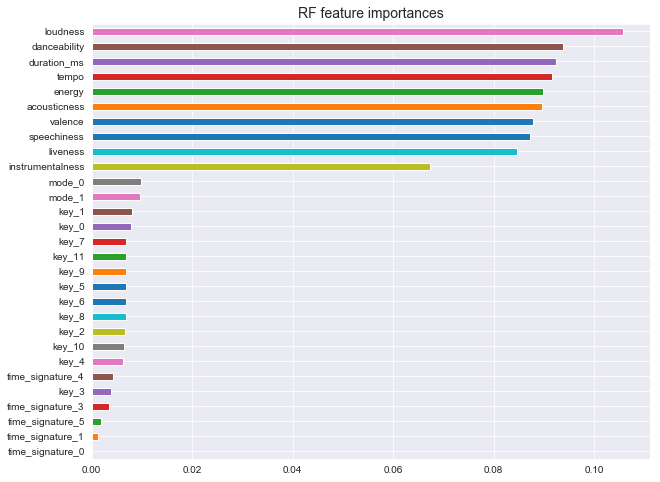

In [33]:
important = pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values()

fig = plt.subplots(figsize=(10,8))
_ = important.plot(kind='barh')
_ = plt.title('RF feature importances', fontsize=14)

As the EDA section indicated, loudness is the most important variable, followed by danceability. Somewhat surprising is that duration is ranked so highly. However, popular songs do tend to be of similar durations, and very long songs might hinder repeat listens, so it seems plausible that duration is important. The categorical variables all rank toward the bottom, but they are split up so their importance might be magnified when considered collectively. Ultimately, no single feature clearly dominates the rest. 

#### Boosting
Finally, I also ran AdaBoost and Gradient Boosting to see if the model improves when running sequentially.

In [34]:
%%time

from sklearn.ensemble import AdaBoostClassifier

dt_b = DecisionTreeClassifier(max_depth=1, random_state=state)

adb = AdaBoostClassifier(base_estimator=dt_b, n_estimators=200)

adb.fit(X_train, y_train)

adb_pred = adb.predict(X_test)

print(accuracy_score(adb_pred, y_test))

0.8584421052631579
Wall time: 1min 5s


In [36]:
%%time

from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(max_depth=3, n_estimators=200, random_state=state)

gb.fit(X_train, y_train)

gb_pred = gb.predict(X_test)

print(accuracy_score(gb_pred, y_test))

0.8581894736842105
Wall time: 1min 48s


The results are more or less the same with AdaBoost and gradient boosting, and are a slight down grade from random forest.<br>
<br>
The accuracy seems to have plateaued, so it's time to dig in to some other metrics.

### Confusion matrix
More important than simple accuracy, the real value add of this project would be the ability to predict popular songs. This can be tested through a confusion matrix. For each of the tables below, the data point of interest is in the second column of the second row.

##### Bagging

In [37]:
from sklearn.metrics import confusion_matrix

bc.fit(X_train, y_train)

confusion_matrix(y_test, bc.predict(X_test))

array([[    0,     0,  3142],
       [    0,     0,   218],
       [    0,     0, 20390]], dtype=int64)

##### Random forest

In [38]:
confusion_matrix(y_test, rf_pred)

array([[   69,     0,  3073],
       [    4,     5,   209],
       [   16,     3, 20371]], dtype=int64)

##### Boosting

In [39]:
confusion_matrix(y_test, adb_pred)

array([[    0,     0,  3142],
       [    0,     0,   218],
       [    2,     0, 20388]], dtype=int64)

Despite the decent accuracy scores from each model, they all scored poorly in the desired task of predicting popular songs. The bagging and AdaBoost models basically predicted everything as unpopular with zero true positives for the minority class, while the random forest model wasn't much better. 

#### Class weights
In an effort to make some improvements, the next move was to adjust the weights applied to the class labels. By applying larger weights to the minority classes, the idea is that the model will give those labels more emphasis. This way, we can direct the model to focus more on producing true positives for the class of interest.<br>
<br>
I first applied this to the bagging model to test the effect.

In [40]:
dt_bal = DecisionTreeClassifier(max_depth=2, class_weight='balanced', random_state=state)
bc_bal = BaggingClassifier(base_estimator=dt_bal, n_estimators=200)

bc_bal.fit(X_train, y_train)

bcb_p = bc_bal.predict(X_test)

print(accuracy_score(bcb_p, y_test))

0.4829894736842105


In [41]:
confusion_matrix(y_test, bcb_p)

array([[  676,  1557,   909],
       [   49,   146,    23],
       [ 3307,  6434, 10649]], dtype=int64)

Re-running bagging with balanced weights, the accuracy is much worse, but the recall for popular songs is greatly improved. Encouraginly, the majority of the popular songs were predicted correctly, which is most important. Unfortunately, there are 6400 false positives from the unpopular class to sift through now.

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, bcb_p, np.unique(y_test)))

              precision    recall  f1-score   support

      medium       0.17      0.22      0.19      3142
     popular       0.02      0.67      0.03       218
   unpopular       0.92      0.52      0.67     20390

   micro avg       0.48      0.48      0.48     23750
   macro avg       0.37      0.47      0.30     23750
weighted avg       0.81      0.48      0.60     23750



Using the above chart helps understand how well the model really worked. Of the 218 popular observations, 149 were predicted correctly for a recall of 67%. However, of the thousands of observations predicted as popular, only 149 truly were, leading to a precision of only 2% and an F1-score of only 0.03. <br>
<br>
Next is a re-run of random forest and AdaBoost, but now with the balanced weights to see if further improvement is possible. For these I manually adjusted the weights to add additional emphasis on the popular class.

In [43]:
rf_b = RandomForestClassifier(max_depth=100, n_estimators=300, min_samples_leaf=1,\
                            class_weight={'medium': 2.475, 'popular': 100, 'unpopular': 1}, random_state=state)

rf_b.fit(X_train, y_train)

rfb_p = rf_b.predict(X_test)

print(accuracy_score(rf_pred, y_test))

0.8608421052631579


In [44]:
print(classification_report(y_test, rfb_p, np.unique(y_test)))

              precision    recall  f1-score   support

      medium       0.78      0.02      0.04      3142
     popular       0.83      0.02      0.04       218
   unpopular       0.86      1.00      0.93     20390

   micro avg       0.86      0.86      0.86     23750
   macro avg       0.82      0.35      0.34     23750
weighted avg       0.85      0.86      0.80     23750



Less than ideal results. For some reason, even with the emphasized popularity, the results have shifted back towards higher precision at the cost of predicting fewer popular songs correctly.<br>
<br>
Now with boosting.

In [45]:
dt_bal = DecisionTreeClassifier(max_depth=2,\
                                class_weight={'medium': 2.475, 'popular': 150, 'unpopular': 1},\
                                random_state=state)

ad_bal = AdaBoostClassifier(base_estimator=dt_bal, n_estimators=200)

ad_bal.fit(X_train, y_train)

ad_bal_p = ad_bal.predict(X_test)

print(accuracy_score(ad_bal_p, y_test))

0.7551578947368421


In [46]:
print(classification_report(y_test, ad_bal_p, np.unique(y_test)))

              precision    recall  f1-score   support

      medium       0.23      0.07      0.10      3142
     popular       0.03      0.39      0.06       218
   unpopular       0.88      0.87      0.87     20390

   micro avg       0.76      0.76      0.76     23750
   macro avg       0.38      0.44      0.34     23750
weighted avg       0.79      0.76      0.76     23750



These results are a little better than the ones for random forest, but it would be nice if the model predicted more popular songs. <br>
<br>
As it stands now, I think the bagging model best achieves it's goal. It's ultimately up to the stake holder, but the fact that the bagging model does the best at predicting popular songs is key, in my opinion. The performance likely isn't ideal, but for someone trying to sift through songs to pick out the best candidates, it's better to have to deal with only a few thousand as opposed to tens of thousands. Also, if these results were generalized to a new batch of songs only in the hundreds, then narrowing that down by 80-90% makes the task quite manageable.

### Applying the model to the hold-out set
Having tested several models, it's finally time to apply them to the final hold-out set to see if the results hold up. After splitting the `final_test` dataset into X and y variables, the data is applied to the bagging, random forest and AdaBoost models.

In [47]:
X_final = final_test.drop('pop_rating', axis=1)
y_final = final_test.pop_rating

holdout_p = bc_bal.predict(X_final)

print(accuracy_score(holdout_p, y_final))

0.48404413957649867


In [48]:
confusion_matrix(y_final, holdout_p)

array([[ 517, 1129,  602],
       [  27,  113,    8],
       [2388, 4496, 7485]], dtype=int64)

In [49]:
print(classification_report(y_final, holdout_p, np.unique(y_final)))

              precision    recall  f1-score   support

      medium       0.18      0.23      0.20      2248
     popular       0.02      0.76      0.04       148
   unpopular       0.92      0.52      0.67     14369

   micro avg       0.48      0.48      0.48     16765
   macro avg       0.37      0.50      0.30     16765
weighted avg       0.82      0.48      0.60     16765



The results above for bagging are actually slightly better than results from the train/validation data. The recall for popularity is 76% here, as opposed to 67%, and the F-1 score is better.<br>
<br>
Now with random forests:

In [50]:
rf_ho_p = rf_b.predict(X_final)

print(accuracy_score(rf_ho_p, y_final))

0.8600656128839845


In [51]:
confusion_matrix(y_final, rf_ho_p)

array([[   57,     1,  2190],
       [    0,     5,   143],
       [   10,     2, 14357]], dtype=int64)

In [52]:
print(classification_report(y_final, rf_ho_p, np.unique(y_final)))

              precision    recall  f1-score   support

      medium       0.85      0.03      0.05      2248
     popular       0.62      0.03      0.06       148
   unpopular       0.86      1.00      0.92     14369

   micro avg       0.86      0.86      0.86     16765
   macro avg       0.78      0.35      0.35     16765
weighted avg       0.86      0.86      0.80     16765



Again, the results are slightly better than the results from the validation set, but the performance is genrally the same.<br>
<br>
And finally, with boosting:

In [53]:
adb_ho_p = ad_bal.predict(X_final)

print(accuracy_score(adb_ho_p, y_final))

0.7567551446465851


In [54]:
confusion_matrix(y_final, adb_ho_p)

array([[  157,   479,  1612],
       [   13,    68,    67],
       [  490,  1417, 12462]], dtype=int64)

In [55]:
print(classification_report(y_final, adb_ho_p, np.unique(y_final)))

              precision    recall  f1-score   support

      medium       0.24      0.07      0.11      2248
     popular       0.03      0.46      0.06       148
   unpopular       0.88      0.87      0.87     14369

   micro avg       0.76      0.76      0.76     16765
   macro avg       0.38      0.47      0.35     16765
weighted avg       0.79      0.76      0.76     16765



The trend holds true for AdaBoost as well: the recall for popular songs is slightly improved, but the results for the final test data are generally the same as for the validation set.<br>
<br>
Based on the tests, the model appears to be generalizable and work comparably on unseen data. Now the trick is pitching to the stakeholder that the performance of this model would be beneficial.

## Conclusions

To recap, here is an overview of the performance of all the models ran.

#### Linear Regression Results
| Algorithm                             | Score  | Custom Loss Average | Execution Time |
|---------------------------------------|--------|---------------------|----------------|
| Linear Regression - No categoricals   | 0.0979 | 14.24               | 78.1 ms        |
| Linear Regression - With categoricals | 0.0994 | 14.22               | 93.4 ms        |
| Ridge Regression                      | 0.1004 | 14.34               | 67.6 ms        |

#### Classification Results
| Algorithm          | Validation Set Score | Validation Set Popular Recall | Hold Out Popular Recall | Execution Time |
|-------------------|----------------------|-------------------------------|-------------------------|----------------|
| Decision Tree     | 0.8585               | 0                             | --                      | 1.03 s         |
| Bagging           | 0.8571               | 0.67                          | 0.76                    | 18.6 s         |
| Random Forest     | 0.8608               | 0.02                          | 0.03                    | 40.1 s         |
| Gradient Boosting | 0.8582               | --                            | --                      | 1 min 48 s     |
| AdaBoost          | 0.8584               | 0.39                          | 0.46                    | 1 min 5 s      |

For the regression algorithms, there isn't much delineation in any category. As for the classification models, the difference depends on the metric. When it comes to basic accuracy they all performed more or less the same. The random forest model is slightly more precise than the rest, but that advantage is nullified by the poor predictive performance. Meanwhile, bagging technically has the lowest accuracy score, but it was far away the best at predicting popular songs. Additionally, the run time compares favorably with most of the models giving the bagging model a nice balance of effectiveness and computational performance. Based on the results above, I think it's clear that the bagging model is the best choice.

<b>Example cases</b><br>
Having settled on the bagging model, we can finally test the model on the example cases that were set aside previously to get a sense of how it might work in the real world.<br>
Here, I shuffle the cases, shape the data to match the training datasets, and split the features and target variable into X and y variables. Finally, I predict the class labels and store the predictions as a dataframe to be merged with the original cases data to create the `results` dataset. Calling this dataset allows us to compare the actual labels with the predicted labels.

In [77]:
cases_mix = cases.sample(frac=1.0, random_state=state).reset_index(drop=True)

cases_drop = cases_mix.drop(['artist_name', 'track_name', 'popularity'], axis=1)
cases_enc = pd.get_dummies(cases_drop, columns=['key', 'mode', 'time_signature'])

cases_X = cases_enc.drop(['pop_rating'], axis=1)
cases_y = cases_mix[['pop_rating']]

cases_pred = pd.DataFrame(bc_bal.predict(cases_X), columns=['predicted_pop'])

In [80]:
results = pd.concat([cases_mix, cases_pred], axis=1)
results.iloc[:,[0,1,15,16,17]]

,artist_name,track_name,popularity,pop_rating,predicted_pop
0,The Weeknd,Try Me,54,medium,unpopular
1,Jonas Brothers,Cool,84,popular,popular
2,Tame Impala,Patience,80,popular,unpopular
3,The Weeknd,Privilege,71,medium,unpopular
4,Jonas Brothers,Sucker,98,popular,popular
5,Shakira,Clandestino,80,popular,popular
6,The Weeknd,Call Out My Name,82,popular,medium
7,Shakira,Waka Waka (This Time for Africa),34,unpopular,popular
8,The Weeknd,Hurt You,73,medium,unpopular
9,The Weeknd,Wasted Times,75,popular,medium


Of the seven songs actually classified as popular, four were predicted correctly. Obviously, we would like to see that ratio be a bit higher, but we can justify it a bit by pointing out that one of the popular songs has a popularity score of 75. This is right on threshold of being considered popular, and the model did predict it as medium. Also worth mentioning, we see that the song Waka Waka was predicted as popular despite being labelled as unpopular, but at one point in time this song was in the U.S. top 40, and reached number 1 in many countries around the world. The model might accurately identify the song characteristics, but the song's age might interfere with the result. In any case, it's nice to see more hits than misses, keeping in mind that the sample size is small.

### <b>Final Thoughts</b><br>
Thinking intuitively about the Spotify data and song popularity in general, it seems apparent that clear cut correlations between a song's features and its popularity would be difficult to discern. Two songs may be structured very similarly, and yet may have entirely different popularity scores. On the other side of the coin, two songs with the same popularity score may sound completely different. One song may be fast and the other slow; one may be loud while the other not so much. The EDA and the feature importances from above demonstrate that there isn't a clear set of features to pinpoint as a surefire predictor of popularity. This makes sense, because if there were a clear formula for increasing a song's popularity then every song would be popular which, inherently, is not possible.<br>
<br>
All of this speaks to the difficulty, perhaps even folly, of trying to predict song popularity, particularly through numeric data. There is just too much confounding information and too many factors that are difficult to quantify. For example, things like an artist's image, name recognition or unforeseen cultural trends all play a role in determining what is popular, and all of these are difficult or simply impossible to convey mathematically.<br>
<br>
On the other hand, the final model did seem to make some gains. It was able to predict most popular songs correctly, albeit with low total precision, and the results of the validation data were generalizable to the unseen hold out data. I think a music programmer or executive would benefit from the model. They would still need to sift through a number of unpopular songs to find the popular songs, but the total amount of work could potentially be greatly reduced. Perhaps this isn't quite the gain we were hoping for, but it is a net gain overall, which is at least part of the goal.

Below is a script for creating a table of contents. This does not render in Github, but can be used with <a href="https://nbviewer.jupyter.org/">nbviewer</a>.

In [7]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>